Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
SPDX-License-Identifier: Apache-2.0

# Learning Gremlin - Ordering, Functions, and Grouping

This notebook is the third in a series of notebooks that walk through how to write queries using Gremlin.  

In this notebook, we will examine the basics of how to perform ordering, grouping, and aggregation in Gremlin.  This notebook assumes that you have already completed the previous notebook "01-Basic-Read-Queries" so we will continue our lessons from the end of the previous notebook and assume that the data has been loaded into the cluster.

### Setting up the visualizations

Run the next two cells to configure various display options for our notebook, which we will use later on to display our results in a pleasing visual way.  

In [ ]:
%%graph_notebook_vis_options
{
  "groups": {    
    "person": {
      "color": "#9ac7bf"
    },
    "review": {
      "color": "#f8cecc"
    },
    "city": {
      "color": "#d5e8d4"
    },
    "state": {
      "color": "#dae8fc"
    },
    "review_rating": {
      "color": "#e1d5e7"
    },
    "restaurant": {
      "color": "#ffe6cc"
    },
    "cusine": {
      "color": "#fff2cc"
    }
  }
}

In [ ]:
node_labels = '{"person":"first_name","city":"name","state":"name","restaurant":"name","cuisine":"name"}'

We'll be using the `node_labels` variable to provide a nicer visualisation when running the queries in this notebook. To use it, we need to pass it along with the query itself, as follows:

`%%gremlin -d node_labels`

The `-d` instructs the notebook as to which properties should be displayed for each specified node label.

### Looking at our graph data

As we examined the data model in the previous notebook, we are not going to examine it, however we will leave the data schema for reference.

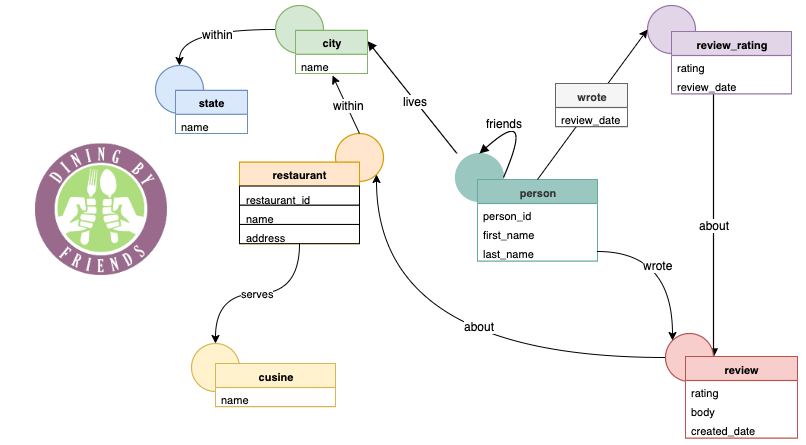


## Ordering Results

When working with data, one common requirement is to return that data in a consistent and ordered fashion.  

By default, data returned from an Gremlin query does not have a specified order, and consistent order cannot be assumed across multiple executions of the same query. To give our data a consistent order we must use the combination of the `order()` and `by()` steps. These enable you sort your results using the values that a query can return, such as nodes/edges, ID values, as well as via many expressions.  

**Note** When the data being ordered contains a `null` value, these will be sorted to the end of the results for ascending sort order and the beginning of the list for descending sort order.


### Ordering by a property

The simplest ordering in Gremlin is to specify a single property.  This is accomplished using the `order().by(<property name>)` syntax. By default, items are ordered in ascending order and descending order can be specified using `order().by(<property name>, desc)`.  

Let's first look at what our data looks like to find all the `restaurant` nodes in our graph and return the `name` property.

In [ ]:
%%gremlin
g.V()
.hasLabel('restaurant')
.values('name')

As we see, there is no discernible order to the values returned.  

Let's see how to order our data by executing the query below to find all the `restaurant` nodes in our graph and order them by the `name` property in descending order.

In [ ]:
%%gremlin
g.V()
.hasLabel('restaurant')
.order()
.by('name', desc)
.values('name')

As we see, with the addition of the `order().by()` steps we get our data returned in a nice organized manner.  

### Ordering by multiple properties

A common need when ordering data is to use multiple properties as the ordering criteria.  In Gremlin, this is achieved by adding multiple `by()` steps to the `order()` step. When multiple properties are specified, the results are first ordered by the first property, then for equal values, the next property, and so on for all the specified properties.  

Let's see how this works by executing the query below to find all the `restaurant` nodes in our graph and order them by the `name` property, then by the `address` property.

In [ ]:
%%gremlin
g.V()
.hasLabel('restaurant')
.order()
.by('name',desc)
.by('address',asc)
.valueMap('name','address')

You can also use internal properties such as `id` and `label` as the ordering criteria. In the examples below, we first show how to order by the object `id`, and then show how to order by the object `label`.

In [ ]:
%%gremlin
g.V()
.hasLabel("restaurant")
.order().by(id)
.values('name')

In [ ]:
%%gremlin
g.V()
.hasLabel("restaurant","state")
.order().by(label, desc)
.values('name')

**Important**: Ordering a small set of data (<1M records) in Neptune should be performant. However, when ordering larger data sets (+1M records), it's likely to experience high latency. In this scenario, the recommendation is to query for the results, then use a caching layer such as [Redis Sorted Sets](https://docs.aws.amazon.com/AmazonElastiCache/latest/red-ug/elasticache-use-cases.html#elasticache-for-redis-use-cases-gaming) to perform the ordering and return the data back to the client.

### Pagination

One of the most common requirements for applications is the ability to return the data in chunks, or pages in the response.  Gremlin supports pagination through the use of three steps: `range()`, and `skip()` and `limit()`.  

We have already used the `limit()` step to specify the maximum number of entities returned. When used with the `skip()` step, which specifies the number of records to ignore at the beginning of the result set, we can create an effective pagination mechanism. One important thing to note about pagination is that we need to explicitly order the results to retrieve a consistent set of data in our pages. Without ordering the results, we have no guarantee that results will be returned in a constant order, meaning that the data shown for a specific "page" may differ between calls.

Let's take a look at how we could use `skip()` and `limit()` to present a paginated view of the restaurants in our graph by retrieving the first page of results.

In [ ]:
%%gremlin
g.V()
.hasLabel("restaurant")
.order().by("name")
.skip(0)
.limit(10)
.values("name")

Let's see what it looks like to retrieve the second page of data. To accomplish this, we need to set the value in the `skip()` step to represent the page size we would like to skip.

In [ ]:
%%gremlin
g.V()
.hasLabel("restaurant")
.order().by("name")
.skip(10)
.limit(10)
.values("name")

As we see, the data we retrieve from the second query represents the second page of results returned from our query.  Please don't hesitate to try additional values for the `skip()` and `limit()` values to see how the query reacts.

Let's now take a look at how we can use the `range()` step to perform pagination in Gremlin.

In [ ]:
%%gremlin
g.V()
.hasLabel("restaurant")
.order().by("name")
.range(0,10)
.values("name")

Let's see what it looks like to retrieve the second page of data. To accomplish this, we need to set the value in the `range()` step to represent the page size we would like to return.

In [ ]:
%%gremlin
g.V()
.hasLabel("restaurant")
.order().by("name")
.range(10,20)
.values("name")

When should you use one approach over the other? In some cases, both `limit()` and `skip()` are shorthand alternatives to `range()`. For example, to retrieve all restaurants from the 10th record to the end of the list, we can use the following approaches:

`g.V().hasLabel("restaurant").skip(5)`

or

`g.V().hasLabel("restaurant").range(5,-1)`

**Important**. When using pagination it's important to understand that even though you're returning a range of records, the query must still retrieve all records and then filter out records outside of the range you're asking for. Therefore, pagination does not improve query performance. Instead, you should use the [Gremlin query results cache](https://docs.aws.amazon.com/neptune/latest/userguide/gremlin-results-cache.html).

The results of both queries are the same, as is the amount of time to execute each query.

Now that we have looked at the ordering and pagination in Gremlin, it's time to take a look at another major set of functionality in formatting Gremlin results, grouping.

## Grouping Results

Grouping results in Gremlin is done by explicitly calling the `group()` or `groupCount()` steps, similar to the `GROUP BY` clause used in SQL. In Gremlin, grouping is also controlled by the use of aggregating expressions containing one or more aggregating functions (`mean()`, `count()`, `max()`, `min()`, `sum()`).

Groups are determined by the use of the `by` modulator step that proceeds either a `group()` or `groupCount()` step. Let's look at an example to understand how this works.

**Example**

|id|first_name|
|---|---|
|1|Dave|
|2|Josh|
|3|Kelly|
|4|Dave|

```
g.V()
.groupCount()
.by('first_name')
.unfold()
```
Results:

|result|
|---|
|{'Dave': 2}|
|{'Josh': 1}|
|{'Kelly': 1}|

In this example, we're counting the number of each occurrence of the `first_name` property value, and then returning it alongside the `first_name` value itself. Similarly, we could use the `group()` step instead, and combine it with the `count()` aggregation function in a second `by` modulation to do the same thing:

```
g.V()
.group()
.by('first_name')
.by(count())
.unfold()
```
Results:

|result|
|---|
|{'Dave': 2}|
|{'Josh': 1}|
|{'Kelly': 1}|

Before we start on grouping, let's learn about `fold()` and `unfold()` steps, as no doubt the keen eyed amongst you will have noticed that we've been using the `unfold()` step in some of the previous examples.

### Fold and Unfold

The `fold()` step converts individual rows into a list in a single row. The following query is an example of returning all restaurants as a list, rather than individual records.

In [ ]:
%%gremlin
g.V().hasLabel('restaurant')
.values('name')
.fold()

// Results in:
// ["Perryman's", 'Spicy Heat', 'Rare Choice', 'Super Delish', 'Eastern Winds', 'Saucy-Cheesy-Saucers', 'With Pasta', 'With Brine', 'With Wine', 'U-S-A', 'Pick & Go', 'Rare Bull', 'Satiated', 'Good Bull', 'Southern Fire', 'With Salsa', 'With Curry', 'With Shell', 'Taters', 'Awesome Suace', 'Prancing Pony', 'Mexican Hut', 'Rabbitfood', 'Hand Roll', 'Northern Quench', 'Western Granola', 'With Noodles', 'With Sauce', 'Without Chaser', 'With Rice', 'Food For Thought', "Dave's Big Deluxe", 'Quick N Greasy', 'Lonely Grape', 'Breaded & Fried', 'All Night Long', 'Black Pit of Des Pair', 'Without Heat', 'With Ginger', 'Fat Fried Fast']

The `unfold()` step does the opposite, converting a single row of list values into individual rows.

In [ ]:
%%gremlin
g.V().hasLabel('restaurant')
.values('name')
.fold()
.unfold()

// Results in:
//1   Perryman's
//2   Spicy Heat
//3   Rare Choice
//4   Super Delish
//5   Eastern Winds
//6   Saucy-Cheesy-Saucers
//7   With Pasta
//8   With Brine
//9   With Wine
//10  U-S-A

### Group by a property

 the query below, returns all the `person` nodes along with the number of nodes with the matching `first_name` property, and ordered by the `first_name` property in **ascending** order.

In [ ]:
%%gremlin -d $node_labels
g.V().hasLabel('person')
.groupCount()
.by('first_name')
.order()
.by('first_name')
.unfold()

### Group on a pattern match
 
Another common need is to use multiple different elements in a pattern to perform a grouping/aggregation query. To accomplish this, we combine what we know about filtering with what we have just learned about grouping to achieve this aggregation.

Let's take a look at what it would look like to find the average rating of the restaurants in our graph.

In [ ]:
%%gremlin
g.V().hasLabel('restaurant')
.group()
.by('name')
.by(in('about').values('rating').mean())
.unfold()

## Combining Queries

Now that we have learned about all the major features (finding, filtering, formatting, ordering, functions, and grouping) of Gremlin, we have one more topic to discuss in this notebook, how to combine traversals together to create more complex traversals. In Gremlin, we can achieve this by using the `union()` step.

The `union()` step combines the results of 2 or more traversals together and returns the combined result from both traversals.

Let's see what an example `union` step looks like:

In [ ]:
%%gremlin
g.V()
.hasLabel('restaurant')
.union(
    has('name','With Pasta'),
    has('name','With Wine')
)
.values('name')

We can also combine objects from previous traversals into a `union` step using aliases.

In [ ]:
%%gremlin
g.V()
.hasLabel('restaurant').has('name','With Pasta').as('a')
.union(
    select('a'),
    __.V().hasLabel('restaurant').has('name','With Wine')
)
.values('name')

An important point to note that `union` works in the same way as other Gremlin steps in that it uses the *incoming traversal* as its starting point. 

The following query traverses to the `With Pasta` restaurant and then uses a `union` step to combine the results with a traversal to the `With Wine` restaurants. Let's take a look at the results.

In [ ]:
%%gremlin
g.V()
.hasLabel('restaurant').has('name','With Pasta').as('a')
.union(
    select('a'),
    hasLabel('restaurant').has('name','With Wine')
)
.values('name')

Only one result was returned! This is because the second traversal in the `union` step *starts* from the **With Pasta** restaurant, and looks for a `restaurant` node with a `name` property value of **With Wine**. To resolve this, we need to use the `__` **anonymous traversal** technique to search the entire graph, irrespective of the previous traversal.

## Optimizing Query Performance using Caching

**Note:** Whilst not specific to wholly Gremlin, this section is useful to understand the different approaches to optimizing your query performance within Neptune.

Amazon Neptune is a fully managed, memory-optimized graph database. As a result, it will try to store as much of your graph in the local memory of the instance that is executing the query in `Buffer Cache` - a specific local instance cache type - for fast query performance. When the required data is not in the buffer cache, Neptune must retrieve it from shared storage before adding it to the buffer cache, which adds to the latency of your queries.

There are several caching mechanisms supported by Neptune:

* `Buffer Cache` - This is an always-on caching technique, whereby Neptune allocates two-thirds of the memory of your instance for storing requested data. It works on a `FIFO` (First-In-First-Out) basis, meaning older cached data pages are removed first. The ratio of buffer 'hits' (queries that retrieve data from memory rather than shared storage) should always be >= 99.9%. You can monitor this using the [`BufferCacheHitRatio` CloudWatch metric](https://docs.aws.amazon.com/neptune/latest/userguide/cw-metrics.html).

* `Results Cache` - (Gremlin only) This provides a mechanism to cache the results from a specific query on a per-instance basis. It is [disabled by default](https://docs.aws.amazon.com/neptune/latest/userguide/gremlin-results-cache.html#gremlin-results-cache-enabling), and works on an `LRU` (Least Recently Used) basis, meaning older cached keys are removed first. See [Paginated cached query results](https://docs.aws.amazon.com/neptune/latest/userguide/gremlin-results-cache.html#gremlin-results-cache-paginating) for an example of combining results cache with the `range()` step. Note, this cannot be enabled on T instance types.

* `Lookup Cache` - This is an always-on caching technique, but is **only available for D instances, e.g. R5d, and not Serverless**. It uses local instance SSD storage to store property values (strings) or RDF literals for fast retrieval. This can be useful when frequently returning or filtering on a large number of property values.

As a general rule, you should look to optimise your queries by only filtering on, and returning properties that you need. 

In addition, monitoring your cluster and instance health using [CloudWatch metrics](https://docs.aws.amazon.com/neptune/latest/userguide/cw-metrics.html) can alert you to causes for query performance degradation.


## Exercises

Now that we have gone through the main concepts of Gremlin read queries, it's time to put it into practice.  Below are several exercises you can complete to verify your understanding of the material covered in this notebook.  As practice for what you have learned, please write the Gremlin queries specified below.

For these exercises, we will be leveraging the majority of the different entities in our data to show how we would build a common graph pattern known as "collaborative filtering" which is often used to provide recommendations to users based on other's reviews.  Collaborative filtering works on the idea that if two people share the same opinion on a topic, such as a restaurant, then they are more likely to share similar opinions on other topics.  With a graph we can leverage these connections to help provide recommendations based on these patterns of connections.  In these exercises, we will be recommending restaurants to our users based upon reviews.


### Exercise 1: What are the 3 highest rated restaurants?

Using the data model above, write a query that will:

* Find the 3 highest average restaurant rating
* Find the associated `cuisine`
* Return the restaurant name, the cuisine name, and the average rating
* Order the results by average rating descending

The results for this query are:

|Restaurant name|Cuisine|Avg Rating|
|---|---|---|
|Lonely Grape|bar|5.0|
|Perryman's|bar|4.5|
|Rare Bull|steakhouse|4.333333|


In [ ]:
%%gremlin

### Exercise 2: Find the top 3 highest rated restaurants in the city where Dave lives

Using the data model above, write a query that will:

* Find a `person` node(s) with a `first_name` of "Dave"
* Find the `city` that Dave lives in
* Find the average rating of restaurants in that city
* Find the top 3 average ratings
* Return the restaurant name, address, and average rating
* Order by the average rating descending

The results for this query are:

|Restaurant name|Address|Avg Rating|
|---|---|---|
|Dave's Big Deluxe|	490 Ivan Cape|4.0|
|Pick & Go|4881 Upton Falls|3.75|
|Without Chaser|	01511 Casper Fall|3.5|

In [ ]:
%%gremlin

### Exercise 3: Which Mexican or Chinese restaurant near Dave is the highest rated?

Using the data model above, write a query that will:

* Find a `person` node(s) with a `first_name` of "Dave"
* Find the `city` that Dave lives in
* Find the restaurants in that city that serve 'Mexican' or 'Chinese' food
* Find the average rating of those restaurants
* Return the restaurant name, address, and average rating
* Order by the average rating descending
* Return the top 1 result

The results for this query are:

|Restaurant name|Address|Avg Rating|
|---|---|---|
|With Salsa|24320 Williamson Causeway|3.5|

In [ ]:
%%gremlin


### Exercise 4: What are the top 3 restaurants, recommended by his friends, where Dave lives? (Personalized Recommendation)

Using the data model above, write a query that will:

* Find a `person` node(s) with a `first_name` of "Dave"
* Find the `city` that Dave lives in
* Find Dave's friends
* Find reviews written by Dave's friends in the city "Dave" lives in
* Find the average rating of those restaurants
* Return the restaurant name, address, and average rating
* Order by the average rating descending
* Return the top 3

The results for this query are:

|Restaurant name|Address|Avg Rating|
|---|---|---|
|Dave's Big Deluxe|490 Ivan Cape|4.0|
|With Salsa|24320 Williamson Causeway|4.0|
|Satiated|370 Hills Estates|3.666667|

In [ ]:
%%gremlin

## Conclusion

In this notebook, we explored ordering, functions, and grouping in Gremlin queries. These queries are a powerful and common way to format and mutate data within your graph.  This is also the last notebook in the set dedicated to writing read queries.  In the next notebook we will take a look at how to write queries that mutate data through insert, update, and delete operations.